# Import relevant packages: numpy, matplotlib, iris, windsparm, aeolus, cartopy

In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs  
from matplotlib import ticker, cm

import aeolus
from aeolus.calc.stats import cumsum, spatial
from aeolus.coord import volume_weights_cube, area_weights_cube, coord_delta_to_cube, interp_cube_from_height_to_pressure_levels
from aeolus.const import init_const
pcb_const=init_const('proxb')




In [2]:
warnings.filterwarnings("ignore")


# Load the data at daily resolution: ask for availability of dataset and change to local directories

In [4]:
pcb_32 = iris.load('../data/pcb_32_fix_17120_120.nc')
pcb_11_daily = iris.load('../data/pcb_11_7560_120_daily.nc')


# Renaming vertical coordinate and defining relevant functions for calculating spatial averages, volumes of gridboxes, and integration of abundances

In [8]:
def newheight(cubes, max_tslice=-1):            
    for cube in cubes:
        if cube.coords()[1].long_name=='Hybrid height':
            height_new = cube.coord('Hybrid height')
            height_new.rename('level_height')
newheight(pcb_11_daily)
newheight(pcb_32)

In [9]:

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume


def hemisphere_sep(cube):
    daycube=cube.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= 90))
    nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
                                    latitude=lambda v: -90 <= v <= 90)) 
    daymean = meridional_mean(zonal_mean(daycube))
    nightmean = meridional_mean(zonal_mean(nightcube)) 
    return daymean, nightmean

def height_to_pressure(cube, pressurecube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = pressurecube.interpolate(height, iris.analysis.Linear())
    rflux_reg=interp_cube_from_height_to_pressure_levels(cube, p_reg, meridional_mean(zonal_mean(p_reg)).data)
    return rflux_reg 



def vmr_molec(cube, p_cube, t_cube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = p_cube.interpolate(height, iris.analysis.Linear())
    volume = volume_weights_cube2(cube)
    nair=(p_reg*volume)/((1.38*10**(-23))*t_cube) #nair in molec/gridbox
    cube_molec = cube*nair/volume #n_o3 in molec/m3
    cube_molec *= 1e-6
    return cube_molec

def integrate(cube, coord):
    """
    Integrate the cube along a 1D coordinate using the trapezoidal rule.

    Note: `coord` must be one of the dimensional coordinates of the cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube containing the given coordinate.
    coord: str or iris.coords.Coord
        Coordinate for integration.

    Returns
    -------
    iris.cube.Cube
        Integrated cube.
    """
    # TODO: allow non-dim coordinates
    c = cube.coord(coord)
    others = [dc.name() for dc in cube.dim_coords if cube.coord_dims(dc) != cube.coord_dims(c)]
    dim = cube.coord_dims(c)[0]
    data = np.trapz(cube.data, c.points, axis=dim)
    res = next(cube.slices(others)).copy(data=data)
    res.units = cube.units * c.units
    res.remove_coord(c)
    res.rename(f"integral_of_{cube.name()}_wrt_{c.name()}")
    # ensure_bounds(cube, [c])
    # delta = iris.coords.AuxCoord(c.bounds[:, 1] - c.bounds[:, 0], units=c.units)
    # res = multiply(cube, delta, dim=dim).collapsed(c, iris.analysis.SUM)
    return res

# Function plot_tevol_120 takes the output from both cubes to calculate time evolution of the global and hemispheric means of irradiation (S$_{TOA}$), temperature, H$_2$O colmn density and O$_3$ column density. For the 3:2 resonance, the passages through apoastron (dashdot) and periastron (dotted) are also indicated. Included as Figure 7.

# The call to the function cycles_percentages produces a range of further statistical info about the different quantities.

In [13]:
def cycles_percentages(cube_mday, cube_mnight, cube_z_m_mean):
    print(cube_mday.attributes['title'])
    print('max %day diff:',(cube_mday.collapsed('t', iris.analysis.MAX).data
                             -cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data)/cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data*100)
    print('min %night diff:',(cube_mnight.collapsed('t', iris.analysis.MIN).data
                             -cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data)/cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data*100)
    print('max %night diff:',(cube_mnight.collapsed('t', iris.analysis.MAX).data
                             -cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data)/cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data*100)
    print('min %day diff:',(cube_mday.collapsed('t', iris.analysis.MIN).data
                             -cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data)/cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data*100)
    print('Global time mean average:', cube_z_m_mean.collapsed('t', iris.analysis.MEAN).data)
    print('Max over time mean global', cube_mday.collapsed('t', iris.analysis.MAX).data)
    print('Min over time mean global', cube_mday.collapsed('t', iris.analysis.MIN).data)
    print('Max over time mean global', cube_mnight.collapsed('t', iris.analysis.MAX).data)
    print('Min over time mean global', cube_mnight.collapsed('t', iris.analysis.MIN).data)
    print('max %peri diff:',((((cube_z_m_mean.collapsed('t', iris.analysis.MAX))-(cube_z_m_mean.collapsed('t', iris.analysis.MEAN)))
                                       /(cube_z_m_mean.collapsed('t', iris.analysis.MEAN))).data*100))
    print('min %peri diff:',((((cube_z_m_mean.collapsed('t', iris.analysis.MIN))-(cube_z_m_mean.collapsed('t', iris.analysis.MEAN)))
                                       /(cube_z_m_mean.collapsed('t', iris.analysis.MEAN))).data*100))

In [18]:
def plot_tevol_120(cubes1, cubes2, time_mean=False, save=False, sublabel=False,
                   sublabel_t='a'):            
    def process_cubes(cubes, time_mean):
        for cube in cubes:
            if cube.standard_name == 'upward_air_velocity':
                z_wind = cube[:,:,:,:].copy()
                if time_mean:
                    z_wind = z_wind.collapsed('t', iris.analysis.MEAN)
            if cube.standard_name == 'surface_temperature':
                tsurf = cube[:,:,:,:].copy()
                if time_mean:
                    tsurf = tsurf.collapsed('t', iris.analysis.MEAN)            
            if cube.long_name == 'Stash code = 50219':
                o3column = cube[:,:,:,:].copy()
                if time_mean:
                    o3column = o3column.collapsed('t', iris.analysis.MEAN)
            if cube.standard_name == 'toa_incoming_shortwave_flux':
                uvflux = cube[:,:,:,:].copy()
                if time_mean:
                    uvflux = uvflux.collapsed('t', iris.analysis.MEAN)
            if cube.standard_name == 'specific_humidity':
                sh = cube[:,:,:,:].copy()
                if time_mean:
                    sh = sh.collapsed('t', iris.analysis.MEAN)    
            if cube.standard_name == 'air_temperature':
                temp_cube = cube[:,:,:,:].copy()
                if time_mean:
                    temp_cube = temp_cube.collapsed('t', iris.analysis.MEAN)     
            if cube.standard_name == 'air_pressure':
                pres_cube = cube[:,:,:,:].copy()
                if time_mean:
                    pres_cube = pres_cube.collapsed('t', iris.analysis.MEAN)
        return {
            'z_wind': z_wind, 'tsurf': tsurf, 'o3column': o3column, 'uvflux': uvflux,
            'sh': sh, 'temp_cube': temp_cube, 'pres_cube': pres_cube
        }

    data1 = process_cubes(cubes1, time_mean)
    data2 = process_cubes(cubes2, time_mean)
    
    xpos=[]
    xlab=[]
    xpos_p=[]
    xlab_p=[]
    for i in range(0,11):
        xpos.append(7.57+11.186*i)
        xpos.append(2.015+11.186*i)
    for i in range(len(xpos)):
        if i % 2 == 0:
            xlab.append('peri')
        else:
            xlab.append('apo')    

    def process_hemispheric_means(data):
        z_wind_mday, z_wind_mnight = hemisphere_sep(data['z_wind'])
        tsurf_mday, tsurf_mnight = hemisphere_sep(data['tsurf'])
        tsurf_z_m_mean = zonal_mean(meridional_mean(data['tsurf']))
        cycles_percentages(tsurf_mday, tsurf_mnight, tsurf_z_m_mean)
        o3col_mday, o3col_mnight = hemisphere_sep(data['o3column'])
        o3col_z_m_mean = zonal_mean(meridional_mean(data['o3column']))
        cycles_percentages(o3col_mday[:,0], o3col_mnight[:,0], o3col_z_m_mean[:,0])
        uvflux_meanday, uvflux_meannight = hemisphere_sep(data['uvflux'])
        uvflux_z_m_mean = zonal_mean(meridional_mean(data['uvflux']))
        cycles_percentages(uvflux_meanday, uvflux_meannight, uvflux_z_m_mean)
        
        height = [('level_height', data['temp_cube'].coord('level_height').points)]
        sh = data['sh'].interpolate(height, iris.analysis.Linear())
        sh = vmr_molec(sh, data['pres_cube'], data['temp_cube']) * 1e6 * (29.3 / 18.01528)
        sh_vcol = integrate(sh, 'level_height')
        sh_vcol_mday, sh_vcol_mnight = hemisphere_sep(sh_vcol)
        sh_vcol_z_m_mean = zonal_mean(meridional_mean(sh_vcol))
        cycles_percentages(sh_vcol_mday, sh_vcol_mnight, sh_vcol_z_m_mean)

        return {
            'z_wind_mday': z_wind_mday, 'z_wind_mnight': z_wind_mnight,
            'tsurf_mday': tsurf_mday, 'tsurf_mnight': tsurf_mnight,
            'tsurf_z_m_mean': tsurf_z_m_mean, 'o3col_mday': o3col_mday,
            'o3col_mnight': o3col_mnight, 'o3col_z_m_mean': o3col_z_m_mean,
            'uvflux_meanday': uvflux_meanday, 'uvflux_meannight': uvflux_meannight,
            'uvflux_z_m_mean': uvflux_z_m_mean, 'sh_vcol_mday': sh_vcol_mday,
            'sh_vcol_mnight': sh_vcol_mnight, 'sh_vcol_z_m_mean': sh_vcol_z_m_mean
        }

    hemis_means1 = process_hemispheric_means(data1)
    hemis_means2 = process_hemispheric_means(data2)

    plt.figure(figsize=(15, 15))
    
    def plot_panel(index, var1, var2, var3, var4, var5, var6, ylabel):
        plt.subplot(4, 1, index)
        plt.plot(hemis_means1[var1].coord('t').points, hemis_means1[var1].data, color='black', ls='-', label='1:1 - Global')
        plt.plot(hemis_means1[var2].coord('t').points, hemis_means1[var2].data, color='darkorange', ls='-', label='1:1 - 0$^\circ$ hemi')
        plt.plot(hemis_means1[var3].coord('t').points, hemis_means1[var3].data, color='blue', ls='-', label='1:1 - 180$^\circ$ hemi')
        
        plt.plot(hemis_means2[var1].coord('t').points-17000, hemis_means2[var1].data, color='black', ls='--', label='3:2 - Global')
        plt.plot(hemis_means2[var2].coord('t').points-17000, hemis_means2[var2].data, color='orange', ls='--', label='3:2 - 0$^\circ$ hemi')
        plt.plot(hemis_means2[var3].coord('t').points-17000, hemis_means2[var3].data, color='blue', ls='--', label='3:2 - 180$^\circ$ hemi')
        
        plt.ylabel(ylabel, fontsize=20)
        plt.yticks(fontsize=15)
        plt.xticks([])
        for i in range(0, 11):
            #plt.axvline(11.186 * i, ls='dashdot', color='grey')
            plt.axvline(7.57+11.186*i, ls='dotted', color='grey')
            plt.axvline(2.015+11.186*i, ls='dashdot', color='grey')
        plt.axvline(7.57, ls='dotted', color='grey', label='3:2 - Periastron')
        plt.axvline(2.015, ls='dashdot', color='grey', label='3:2 - Apoastron')
        plt.xlim(1, 120)
            
        if index==1:    
            plt.legend(loc='center right', fontsize=14)

    plot_panel(1, 'uvflux_z_m_mean', 'uvflux_meanday', 'uvflux_meannight', 'uvflux_z_m_mean', 'uvflux_meanday', 'uvflux_meannight', 'S$_{\mathrm{TOA}}$ (Wm$^{-2}$)')
    plot_panel(2, 'tsurf_z_m_mean', 'tsurf_mday', 'tsurf_mnight', 'tsurf_z_m_mean', 'tsurf_mday', 'tsurf_mnight', 'T$_{\mathrm{surf}}$ (K)')
    plot_panel(3, 'sh_vcol_z_m_mean', 'sh_vcol_mday', 'sh_vcol_mnight', 'sh_vcol_z_m_mean', 'sh_vcol_mday', 'sh_vcol_mnight', 'H$_2$O col (molec m$^{-2}$)')
    
    plt.subplot(4, 1, 4)
    plt.plot(hemis_means1['o3col_z_m_mean'][:,0].coord('t').points, hemis_means1['o3col_z_m_mean'][:,0].data, color='black', ls='-', label='Global - 1:1')
    plt.plot(hemis_means1['o3col_mday'][:,0].coord('t').points, hemis_means1['o3col_mday'][:,0].data, color='darkorange', ls='-', label='0$^\circ$ hemi - 1:1')
    plt.plot(hemis_means1['o3col_mnight'][:,0].coord('t').points, hemis_means1['o3col_mnight'][:,0].data, color='blue', ls='-', label='180$^\circ$ hemi - 1:1')
    
    plt.plot(hemis_means2['o3col_z_m_mean'][:,0].coord('t').points-17000, hemis_means2['o3col_z_m_mean'][:,0].data, color='black', ls='--', label='Global - 3:2')
    plt.plot(hemis_means2['o3col_mday'][:,0].coord('t').points-17000, hemis_means2['o3col_mday'][:,0].data, color='orange', ls='--', label='0$^\circ$ hemi - 3:2')
    plt.plot(hemis_means2['o3col_mnight'][:,0].coord('t').points-17000, hemis_means2['o3col_mnight'][:,0].data, color='blue', ls='--', label='180$^\circ$ hemi -3:2')

    plt.ylabel('O$_3$ column (DU)', fontsize=20)
    plt.yticks(fontsize=15)
    plt.xlabel('Orbit', fontsize=22)
    plt.xticks(xpos, labels=xlab, fontsize=20, rotation=75)
    plt.xlim(1, 120)
    for i in range(0, 11):
        #plt.axvline(11.186 * i, ls='dashdot', color='grey')
        plt.axvline(7.57+11.186*i, ls='dotted', color='grey')
        plt.axvline(2.015+11.186*i, ls='dashdot', color='grey')    
    #plt.legend(loc='best', fontsize=12)
    
    if save:
        plt.savefig('pcb_combo_tevol.pdf', bbox_inches='tight')
    plt.show()
    



SURFACE TEMPERATURE AFTER TIMESTEP
max %day diff: [15.036766052246094]
min %night diff: [-15.168623924255371]
max %night diff: [-13.93614387512207]
min %day diff: [14.167049407958984]
Global time mean average: [229.27932739257812]
Max over time mean global [263.75552]
Min over time mean global [261.76144]
Max over time mean global [197.32663]
Min over time mean global [194.50081]
max %peri diff: [0.22644007205963135]
min %peri diff: [-0.2248561680316925]
Stash code = 50219
max %day diff: -21.69278711080551
min %night diff: 21.59787267446518
max %night diff: 26.503127813339233
min %day diff: -26.254624128341675
Global time mean average: 392.42322
Max over time mean global 307.2957
Min over time mean global 289.39398
Max over time mean global 496.42764
Min over time mean global 477.17828
max %peri diff: 0.15465524047613144
min %peri diff: -0.07573728798888624
INCOMING SW RAD FLUX (TOA): ALL TSS
max %day diff: [100.0000228881836]
min %night diff: [-100.0]
max %night diff: [-100.0]
min %da

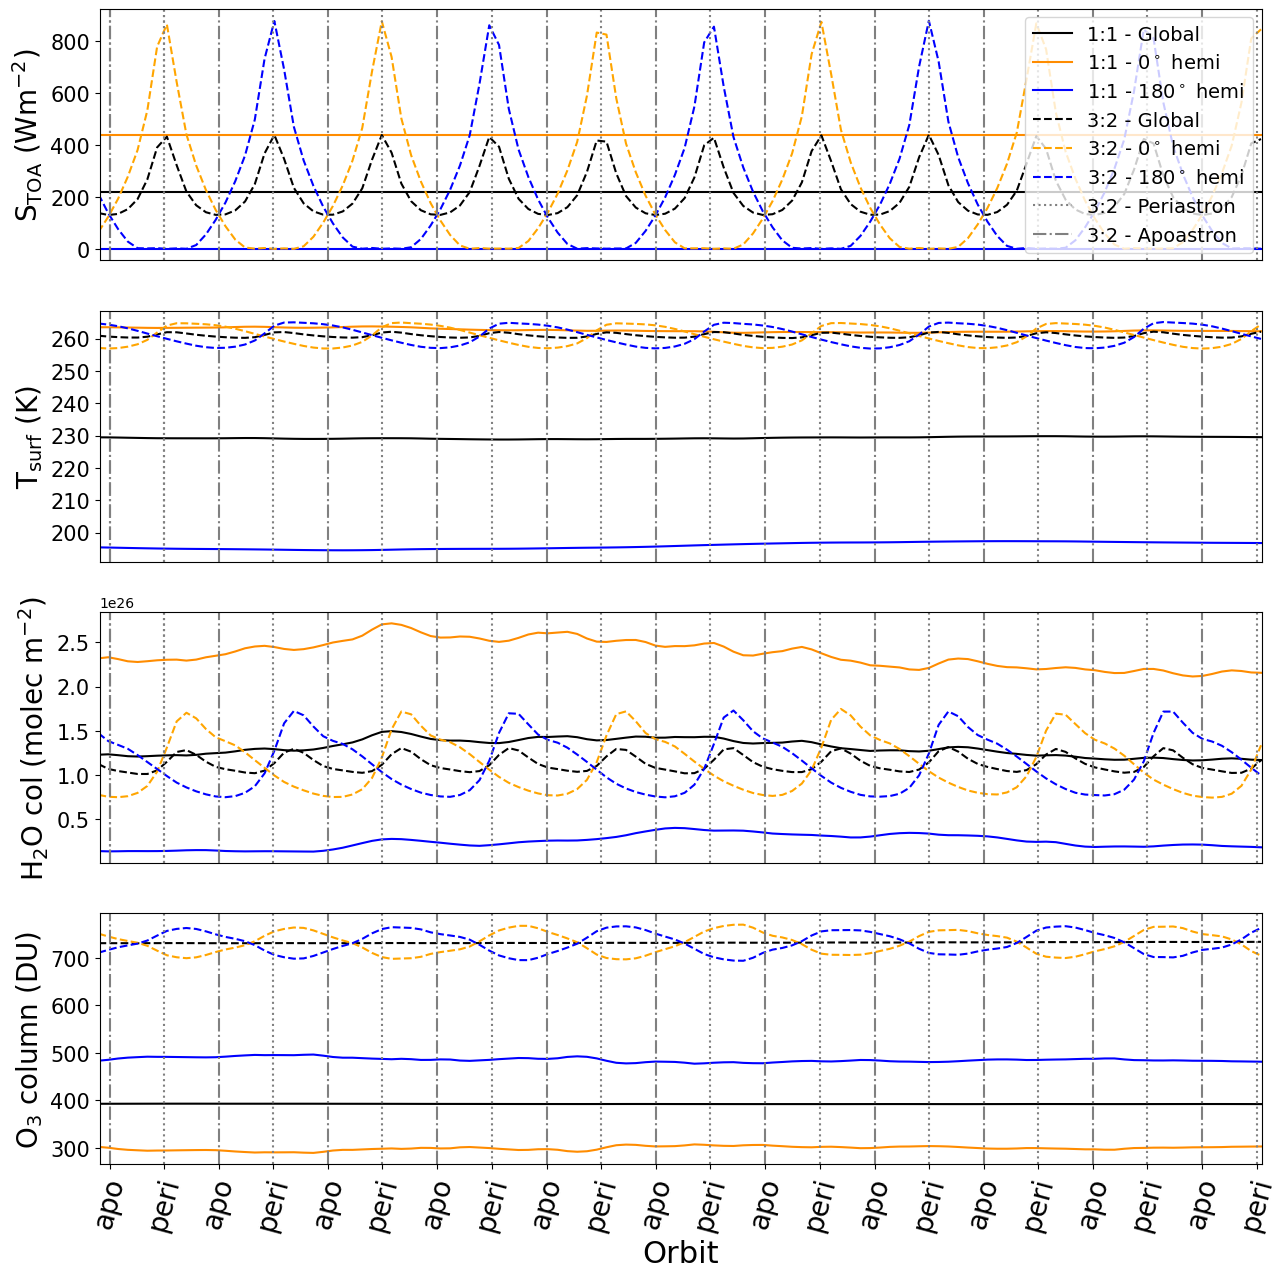

In [19]:
plot_tevol_120(pcb_11_daily, pcb_32, save=True)